# Advanced Lane Finding

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

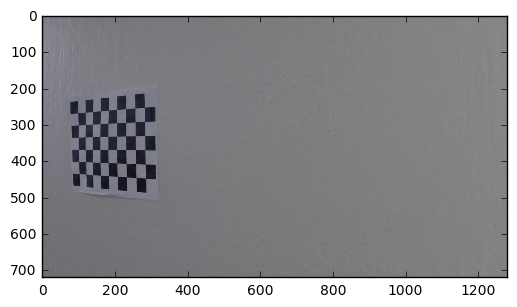

In [2]:
list_images = glob.glob('camera_cal/*')
img_chess = mpimg.imread(list_images[12])
plt.imshow(img_chess)

In [3]:
obj_points = []
img_points = []

nx = 9
ny = 6
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
for im_path in list_images:
    img = mpimg.imread(im_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret:
        img_points.append(corners)
        obj_points.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)


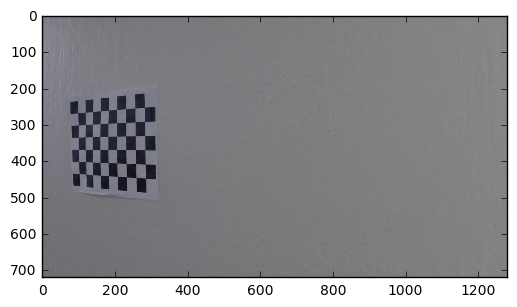

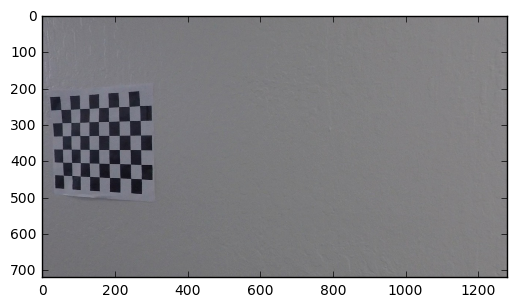

In [4]:
undist = cv2.undistort(img_chess, mtx, dist, None, mtx)
plt.figure()
plt.imshow(img_chess)
plt.figure()
plt.imshow(undist)

## Binarization of images using gradients and color transformation

In [5]:
# functions to get a good mask for an image
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))

    binary_output = scaled_sobel > thresh[0]
    binary_output = binary_output*(scaled_sobel < thresh[1])
    return binary_output


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))
    binary_output = scaled_sobel > mag_thresh[0]
    binary_output = binary_output*(scaled_sobel < mag_thresh[1])
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    angle_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = angle_sobel > thresh[0]
    binary_output = binary_output*(angle_sobel < thresh[1])
    return binary_output


def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_ch = hls[:,:,2]
    binary_output = np.zeros_like(s_ch)
    binary_output[(s_ch > thresh[0]) & (s_ch <= thresh[1])] = 1
    return binary_output

In [6]:
road_list_images = glob.glob('test_images/*')
img_road = mpimg.imread(road_list_images[5])

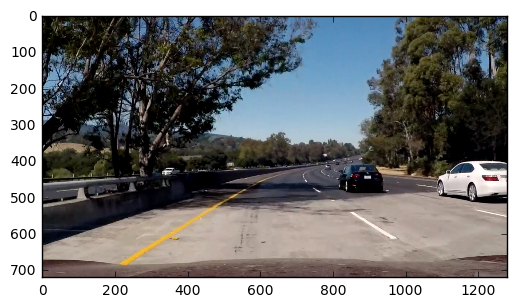

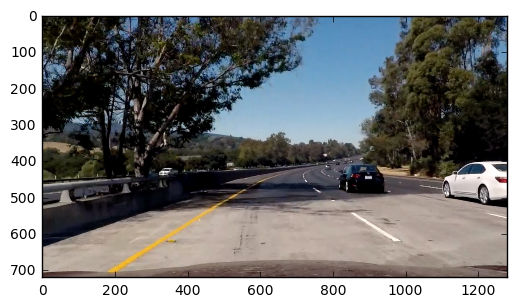

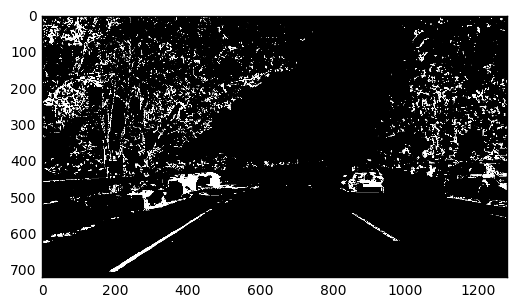

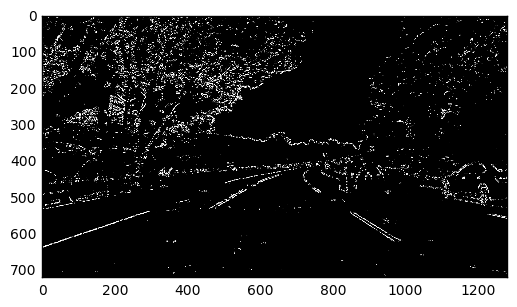

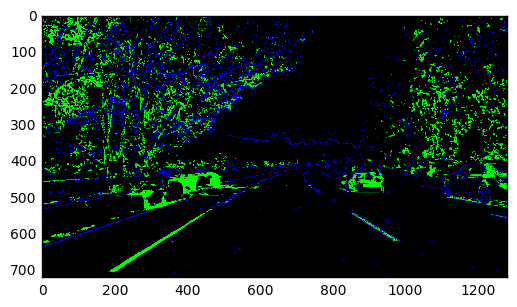

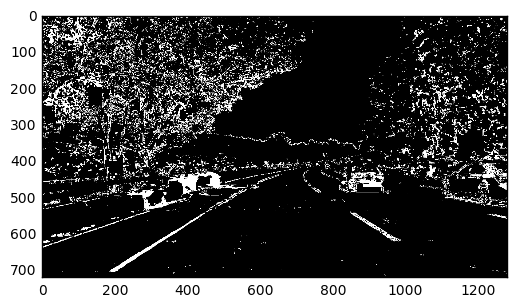

In [35]:
# Apply each of the thresholding functions
ksize=3
img_road_undist = cv2.undistort(img_road, mtx, dist, None, mtx)
gradx = abs_sobel_thresh(img_road_undist, orient='x', sobel_kernel=ksize, thresh=(10, 250))
grady = abs_sobel_thresh(img_road_undist, orient='y', sobel_kernel=ksize, thresh=(30, 120))
mag_binary = mag_thresh(img_road_undist, sobel_kernel=ksize, mag_thresh=(180, 200))
dir_binary = dir_threshold(img_road_undist, sobel_kernel=ksize, thresh=(0.05, 0.8))
s_binary = hls_select(img_road_undist, thresh=(180,255))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | (s_binary == 1)] = 1


gc = np.uint8(np.zeros_like(s_binary))
bc = np.uint8(np.zeros_like(s_binary))
bc[((gradx == 1) & (grady == 1))] = 1
gc[s_binary==1] = 1

color_binary = np.dstack((np.zeros_like(s_binary), 255*gc, 255*bc))


plt.figure()
plt.imshow(img_road)
plt.figure()
plt.imshow(img_road_undist)
plt.figure()
plt.imshow(gc,cmap='gray')
plt.figure()
plt.imshow(bc,cmap='gray')
plt.figure()
plt.imshow(color_binary)
plt.figure()
plt.imshow(combined,cmap='gray')